In [1]:
# style the notebook
from IPython.core.display import HTML
import urllib.request
response = urllib.request.urlopen('http://bit.ly/1LC7EI7')
HTML(response.read().decode("utf-8"))

# Background Detection with Gaussians

First, an important disclaimer - this is not a good algorithm for this problem. I use it merely to indroduce the idea of using probabilities in image detection. The algorithm will trivially fail, which I will demonstrate at the end. but, once you understand the concepts they can be applied in more sophisticated algorithms. There's a lot of material to understand for a modern algorithm. If you don't have a thorough grasp of the material you'd still probably understand the explanation, but be unable to understand the limitations or apply it to your own problem. 

We will try to identify pool (billiard) balls on a table by learning what the background looks like. The background is the table felt, normally green. This is our first simplification - that the background is green and somewhat uniform. 

First, let's pull in and display an image using Pillow. I do not aim to teach Pillow here; a great (and official) guide is here: http://pillow.readthedocs.org/guides.html. I will only use a few features, and you should be able to understand everything I do just by inspecting the code.

In [2]:
%matplotlib inline
from PIL import Image
from __future__ import print_function
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['figure.figsize'] = 8, 8

In [3]:
table = Image.open('empty-table.jpg')
table

There is too much in that image to process easily. Since this is a toy example, I've just cut a close up out of that image, and we will use that to learn the background.

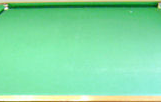

In [4]:
closeup = Image.open('empty-closeup.png')
closeup

My hypothesis is simple. I can represent the background (the table felt) as a Gaussian of the pixel colors of this image. I can then use this Gaussian on other images of tables with balls on them. Pixels that are 'far' from this learned Gaussians are balls (or sticks, or people), those that are close are the felt. In this way I can easily extract the balls from the image.

Difficulties should already suggest themselves. Can we detect green balls? What if the table felt is blue, or dimly lit? What if the image is overexposed, making the felt near white? What if there is a strong light to the side, causing the balls to cast shadows? But let's ignore them, and just learn how to perform this task.

Here we inspect the attributes of the image:

In [5]:
print(closeup.format, closeup.size, closeup.mode)

PNG (161, 102) RGB


It is possible to compute the Gaussian of an RGB value in a couple of ways. We can treat the (R, G, B) tuple as a 24 bit value, or we could independently compute the Gaussians of the red, green, and blue channels separately. An alternative is to convert the image to HSV, which stand for hue, saturation, and value. The hue channel encodes the color of the pixel, which is what we want. 

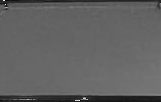

In [6]:
hsv = closeup.convert('HSV')
hue, sat, value = hsv.split()
hue

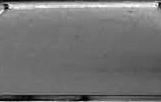

In [7]:
sat

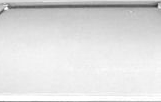

In [8]:
value

Now we can compute the mean and standard deviation of the image.

In [9]:
mean = np.mean(hue)
std = np.std(hue)
print(mean, std)

97.5240530995 19.5328776404


We have 'trained' our model. I put 'trained' in quotes to point out that we are doing a very simple form of machine learning. One sample is hardly enough to account for the universe of pool table images that we might see, so we can't expect the model to handle images very different from the training data. For this tutorial I will use my human eyesight to ensure that the images we use are not 'too far' from the training data.

Now we try this out with images of pool tables with balls, sticks, shadows, and so on. Here is the example that we will be working with:

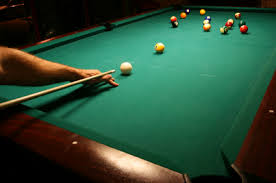

In [10]:
table1 = Image.open('table1.jpg')
table1

Here I have extracted the hue channel from the image:

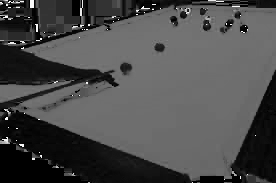

In [11]:
hsv = table1.convert('HSV')
hue, sat, value = hsv.split()
hue

Our job it to label each pixel in the image as either part of the background or not. I can model this as a probability by labelling the pixel as background if its hue is more then some threshhold $t$ standard deviations away from the mean of the training image.

$$P(\text{pixel}=\text{background}) = \big\vert\text{hue}-\text{mean}\big\vert > t*\text{std}$$

Here I compute and display the absolute difference of the image from the mean of the training data: 

In [12]:
import matplotlib.cm as cm
diff = abs(hue - mean)
plt.imshow(diff, cmap=cm.Greys_r);

Problems with the proposed algorithm is already apparent, but lets complete the algorithm by extracting the background. All background pixels should be black, and foreground image white:

In [13]:
match = diff>1.4*std
plt.imshow(match, cmap=cm.Greys_r);

We've somewhat successfully extracted the balls from the pool table. The resolution of the balls in back is quite limited, so I'm fairly happy with the results as far as that goes. But if we look past the edges of the pool table we see how poorly the algorithm is doing. Everything behind the table should be considered the background, yet it has been labeled as the foreground. The reason is clear enough - the background can have many hues, not just the hue of the felt green. Chairs, walls, and basically anything *except* felt will be identified as the foreground.

There are many fixes that suggest themselves. If we know the position and shape of the table felt in our image, we could use a mask to eliminate everything from consideration except the playing surface. That is not a robust solution in general, but might be fine if you are trying to track balls for a pool tournament where the tables and cameras are in fixed positions. I won't pursue that idea because the implementation is trivial and the general utility of a scheme like that is low. 

In the following code I have put the background extraction in a function and shown the result of different thresholds. If the threshold is too low almost none of the image is labeled as the background. If the threshold is too high we cannot reliably detect the shape of the balls. I arrived at the value of 1.4 purely by trial and error - I have no theoretical foundation for choosing a threshold. Perhaps this is something that could be learned via data sets with the balls labeled, but this is just not a very robust algorithm, and I don't want to continue on this path. 

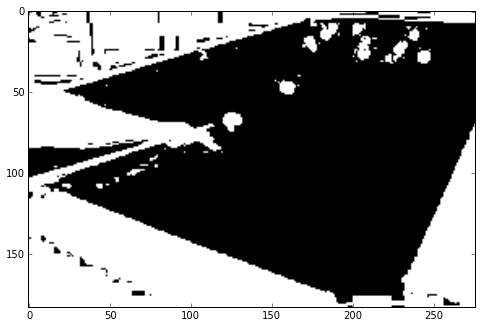

In [14]:
def extract_background(image, mean, std, threshold):
    hsv = image.convert('HSV')
    hue, sat, value = hsv.split()
    diff = abs(hue - mean)
    match = diff > threshold * std
    plt.imshow(match, cmap=cm.Greys_r)
    plt.show()

extract_background(Image.open('table1.jpg'), mean, std, .5)
extract_background(Image.open('table1.jpg'), mean, std, 1.4)
extract_background(Image.open('table1.jpg'), mean, std, 3.5)

## Discussion

This is not an algorithm that will work for anything but the most constrained or contrived problems. Why did I show it?

The idea of this algorithm comes straight from machine learning. In machine learning classification problem there is some  some unknown to us function $f$ that classifies data into various sets. In this problem we are trying to identify which pixels correspond to billiard balls. We create a **hypothesis set** of possible models. In this case our model is constrained to be the Gaussian $\mathcal{N}(\mu, \sigma^2)$ of the hue channel in the image; the parameters are $\mu$ and $\sigma$, or the mean and standard deviation.  The learning algorithm is given a labeled set of data; from it the algorithm learns the parameters of the model. In this case our data set was an image of table felt, and we computed the mean and standard deviation of its hue. Finally, we then used the learned parameters to classify a different image. With enough input data we could have learned the threshold parameter, but in the interests of expediency I just hard coded that value. In short, this should suggest the **Perceptron** machine learning algorithm to you. See my tutorial on perceptrons if you don't know what they are. 


In the language of machine learning this is a **classification** algorithm: we classify each pixel as being part of the background or not. To do this we use [logistic regression](https://en.wikipedia.org/wiki/Logistic_regression)[1] to establish the probability of some feature of the world given measured data: $P(w|x)$. The model of our data given the world, $P(x|W), is a probability distribution function.  **author's note: I know this is not clear, I need to develop these concepts further for those not familar with them.**

## Try your own Images

Here is some code that allows you to grab an image from the internet and display the results:

In [15]:
import io

def get_image(url):
    path = io.BytesIO(urllib.request.urlopen(url).read())
    return Image.open(path)

Here is the result from a different green felt table:

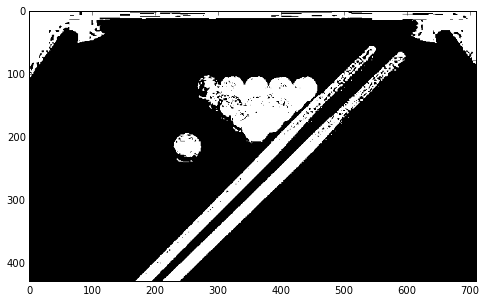

In [16]:
img = get_image('http://varsyshost.com/~pooltabl/wp-content/themes/theme1263/images/slider_img/slider-1.jpg')
extract_background(img, mean, std, 1.4)
img

This exhibits complete failure with a blue felt table:

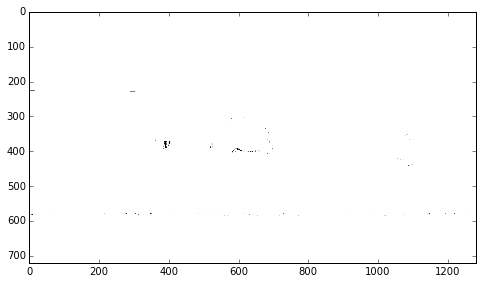

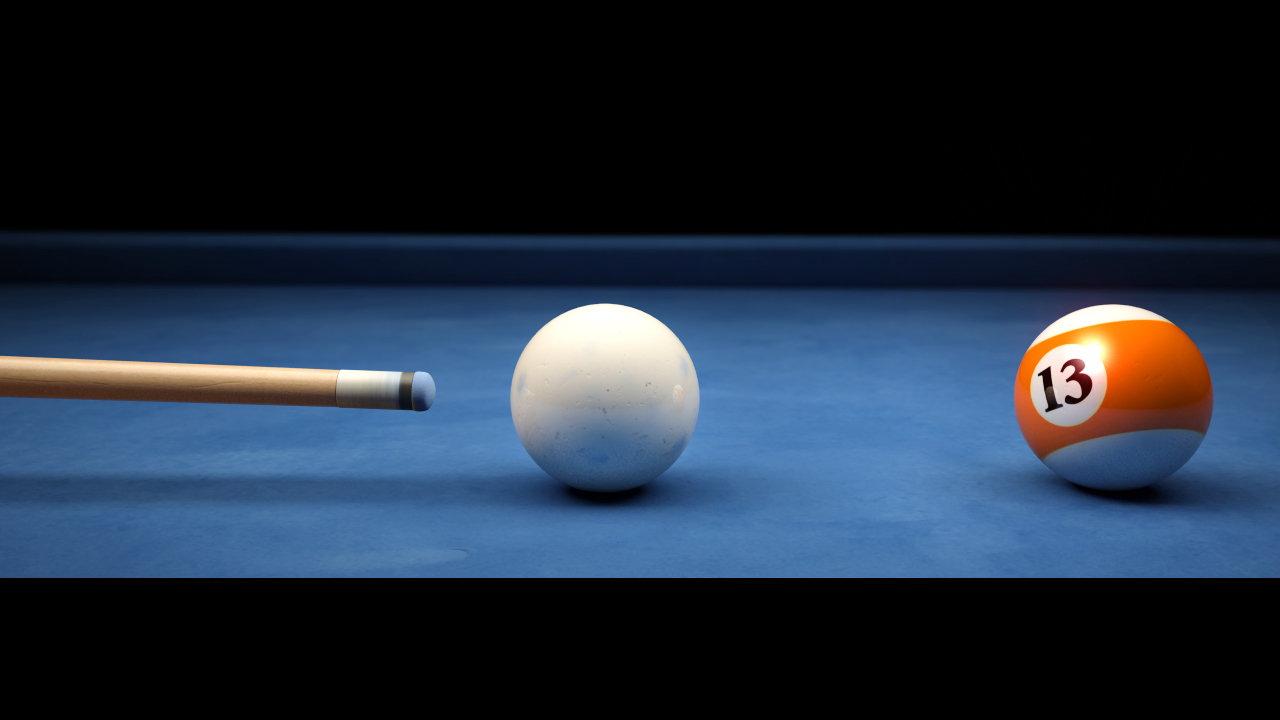

In [17]:
img = get_image('http://jokermartini.com/wp-content/uploads/2012/02/PoolTable_HR.jpg')
extract_background(img, mean, std, 1.4);
img

Finally, here is a golf course:

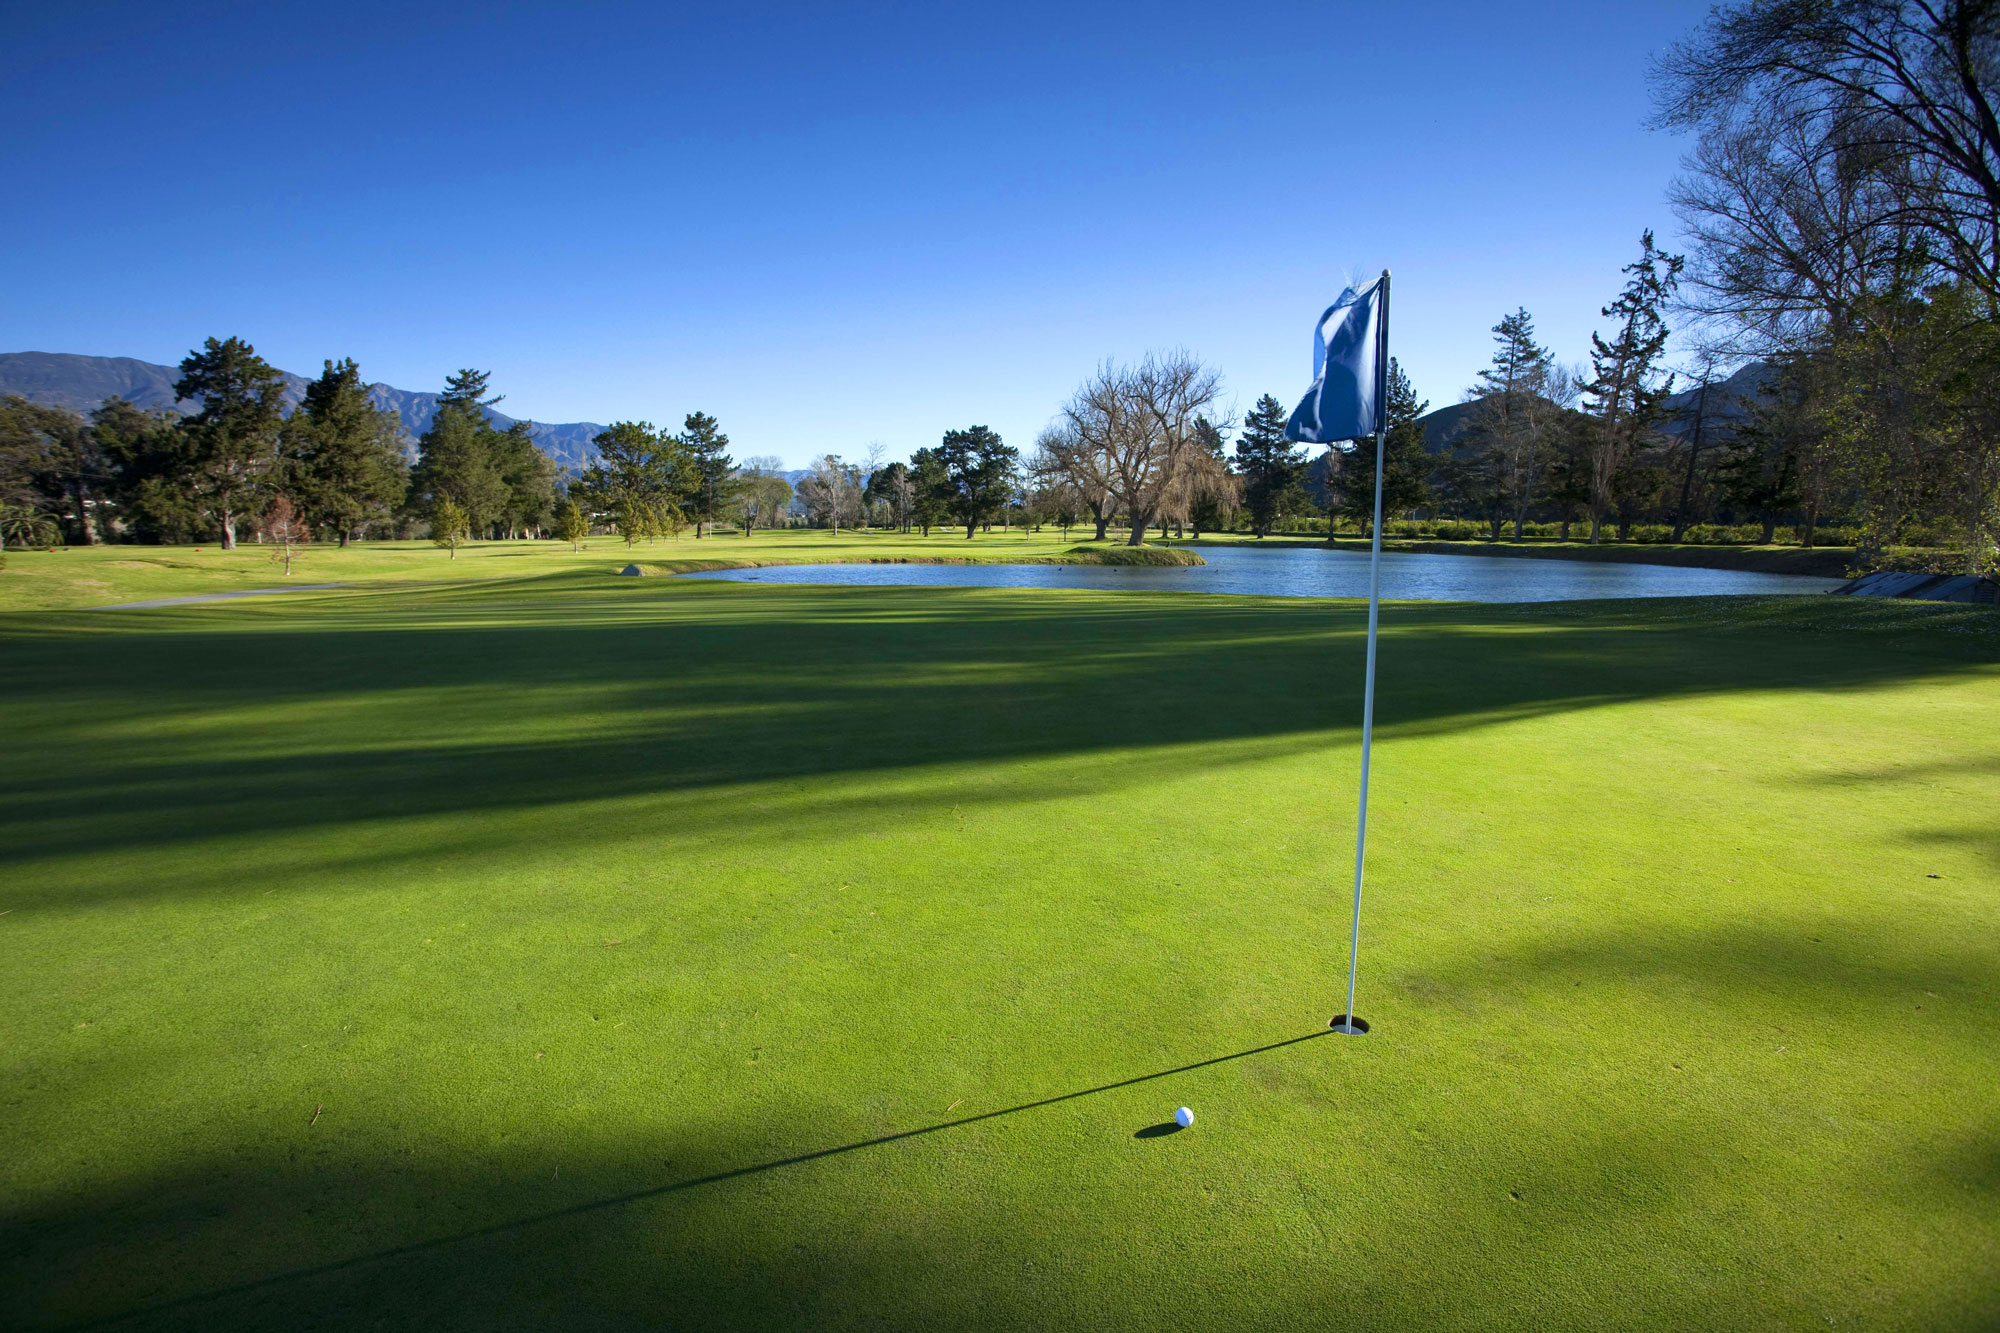

In [18]:
img = get_image('http://mountainviewgolfcourse.net/wp-content/uploads/background/6.jpg')
extract_background(img, mean, std, 1.4);
img

## References

[1] https://en.wikipedia.org/wiki/Logistic_regression